In [13]:
import os
import sys
import cv2
import glob
import pickle
import gc
import json
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim

import copy
import time
import timm
from timm.data import create_transform
from timm import create_model, list_models
from collections import defaultdict
import torch
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn.functional import binary_cross_entropy_with_logits, cross_entropy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import evaluate
from transformers import Mask2FormerConfig, Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import OneFormerConfig, OneFormerImageProcessor, OneFormerForUniversalSegmentation

In [14]:
class model_config:
    """
    Parameters used for training
    """
    seed = 42
    img_size = (512, 512)
    batch_size = 4
    valid_batch_size = 8
    epochs = 2
    current_fold = 0
    learning_rate = 0.002 # 0.001 for bs=16
    scheduler = "CosineAnnealingLR"
    num_training_samples = 5499
    T_max = int(
        num_training_samples / batch_size * epochs)  # number of iterations for a full cycle, need to change for different # of iterations. (iteration = batch size)
    weight_decay = 1e-6  # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    iters_to_accumulate = max(1, 32 // batch_size)  # for scaling accumulated gradients
    eta_min = 1e-5
    model_save_directory = os.path.join(os.getcwd(), "model",
                                        "mask2former_baseline")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)  #numpy specific random
    random.seed(seed)  # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  # torch specific random
    torch.cuda.manual_seed(seed)  # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary

set_seed(model_config.seed)

In [4]:
# no randstain pipeline:
train_transforms = A.Compose([
    A.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1, p = 0.8),
    A.GaussNoise(p=0.2),
    A.ToGray(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
    ToTensorV2() #V2 converts tensor to CHW automatically
])
val_transforms = A.Compose([
    A.Normalize(mean=(0.6801, 0.4165, 0.6313), std=(0.1308, 0.2094, 0.1504)),
                            ToTensorV2()])

In [5]:
class TrainDataSet(Dataset):
    # initialize df, label, imagepath and transforms
    def __init__(self, df, config, transforms=None, label=True):
        self.df = df
        self.label = label
        self.imagepaths = df["image_path"].tolist()
        self.maskpaths = df["mask_path"].tolist()
        self.transforms = transforms

    # define length, which is simply length of all imagepaths
    def __len__(self):
        return len(self.df)

    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.imagepaths[idx]
        # print(image_path)
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        original_image = np.array(image)
        if self.label:
            mask_path = self.maskpaths[idx]
            mask = cv2.imread(mask_path, 0)
            original_segmentation_map = np.array(mask)
        if self.transforms is not None:  #albumentations vs torchvision difference:
            # # torchvision (randstain):
            # image = self.transforms(image)
            # #apply horizontal and vertical flips to image and mask
            # if np.random.rand() < 0.5:
            #     image = np.flipud(image)  #vertical
            #     mask = np.flipud(mask)
            # if np.random.rand() < 0.5:
            #     image = np.fliplr(image)  #horizontal
            #     mask = np.fliplr(mask)
            # # Convert image and mask to tensors
            # image = np.ascontiguousarray(image)
            # image = np.transpose(image, (2, 0, 1))
            # mask = np.ascontiguousarray(mask)
            # image = torch.from_numpy(image.copy())  #.float()
            # mask = torch.from_numpy(mask.copy()).unsqueeze(0)  #.to(torch.uint8)
            #albumentation (no randstain):
            transformed = self.transforms(image=original_image,mask=original_segmentation_map)
            image = transformed['image']
            segmentation_map = transformed['mask']
            # mask = mask.unsqueeze(0)
            # inputs = self.processor.encode_inputs(pixel_values_list=[image],segmentation_maps=[mask],return_tensors='pt')
            # image = torch.float 32, mask = torch.uint8
        # if self.transforms is None: # only for torchvision (randstain), for validation if no val_transforms
        #     image = np.transpose(image, (2, 0, 1))
        #     image = torch.from_numpy(image)
        #     mask = torch.from_numpy(mask).unsqueeze(0)
        return image, segmentation_map, original_image, original_segmentation_map  # return tensors of image arrays, image should be 3x 512 x 512, mask 1 x 512 x 512 (need dummy dimension to match dimension)

In [6]:
class HubmapModel(nn.Module):
    def __init__(self, config):
        super(HubmapModel, self).__init__()
        self.model = Mask2FormerForUniversalSegmentation(config)

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs

In [7]:
config = Mask2FormerConfig(feature_size=512, mask_feature_size=512)
# config.save_pretrained('./config')
metric = evaluate.load("mean_iou")
target_sizes = (512,512)

In [8]:
new_df_train = pd.read_excel(
    r"\\fatherserverdw\Kevin\hubmap\unet++_v2\train_fold{}.xlsx".format(model_config.current_fold))
new_df_val = pd.read_excel(r"\\fatherserverdw\Kevin\hubmap\unet++_v2\val_fold{}.xlsx".format(model_config.current_fold))

In [9]:
def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()  # set mode to train
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    scaler = GradScaler()  # enable GradScaler
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train', colour='red')
    print(pbar)
    for idx, inputs in pbar:
        batch_size = model_config.batch_size  # return batch size N.
        # with autocast(enabled=True, dtype=torch.float16):  # enable autocast for forward pass

        outputs = model(
          pixel_values=batch["pixel_values"].to(model_config.device),
          mask_labels=[labels.to(model_config.device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(model_config.device) for labels in batch["class_labels"]])

        loss = outputs.loss
        loss = loss / model_config.iters_to_accumulate  # need to normalize since accumulating gradients
    scaler.scale(loss).backward()  # accumulates the scaled gradients

    if (idx + 1) % model_config.iters_to_accumulate == 0:  # scale updates should only happen at batch granularity
        scaler.step(optimizer)
        scaler.update()  # update scale for next iteration
        optimizer.zero_grad()  # zero the accumulated scaled gradients
        scheduler.step()  # change lr,make sure to call this after scaler.step

    running_loss += (loss.item() * batch_size)  # update current running loss for all images in batch
    dataset_size += batch_size  # update current datasize
    epoch_loss = running_loss / dataset_size  # get current epoch average loss
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                     lr=f'{current_lr:0.5f}')

    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss  #return loss for this epoch


In [10]:
@torch.no_grad()  # disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval()  # set mode to eval
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    valid_ap_history = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation', colour='red')
    for idx, inputs in pbar:
        outputs1 = model(
      pixel_values=batch["pixel_values"].to(model_config.device),
      mask_labels=[labels.to(model_config.device) for labels in batch["mask_labels"]],
      class_labels=[labels.to(model_config.device) for labels in batch["class_labels"]])
        loss = outputs1.loss
        # y_pred, _ = model(images)  # run this if aux_params (dropout, maxpool, attention)
        # print("mean of y_pred is {}".format(torch.mean(torch.squeeze(y_pred))))
        # print("max of y_pred is {}".format(torch.max(torch.squeeze(y_pred))))
        # print("min of y_pred is {}".format(torch.min(torch.squeeze(y_pred))))
        # print("mean of masks is {}".format(torch.mean(torch.squeeze(masks))))
        # sub_value = torch.mean(torch.squeeze(masks)) - torch.mean(torch.squeeze(y_pred))
        # print("mean of masks minus mean of y_pred is {}".format(sub_value))

        running_loss += (loss.item() * model_config.valid_batch_size)  #update current running loss
        dataset_size += model_config.valid_batch_size  #update current datasize
        epoch_loss = running_loss / dataset_size  #divide epoch loss by current datasize
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}')
        # y_pred = nn.Sigmoid()(
        #     y_pred)  #sigmoid for multi-class, smp loss function has sigmoid in it, but iou_map doesn't have sigmoid.
        # print(torch.max(torch.squeeze(y_pred[0])))
        # print(torch.min(torch.squeeze(y_pred[0])))
        # print(torch.mean(torch.squeeze(y_pred[0])))
        predicted_segmentation_maps = Mask2FormerImageProcessor.post_process_semantic_segmentation(outputs= outputs1,
                                                                                    target_sizes=target_sizes)
        ground_truth_segmentation_maps = inputs["original_segmentation_maps"]
        metric.add_batch(references=ground_truth_segmentation_maps,predictions=predicted_segmentation_maps)
    print("Mean IoU:", metric.compute(num_labels = 2)['mean_iou'])
    valid_ap_history = metric.compute(num_labels = 2)['mean_iou']
    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss, valid_ap_history  #return loss and valid_score_history for this epoch

In [11]:
def run_training(model, optimizer, scheduler, device, train_dataloader, val_dataloader, num_epochs):
    start = time.time()  # measure time
    best_model_wts = copy.deepcopy(model.state_dict())  #deepcopy
    best_ap = 0  # initial best score
    best_epoch = -1  # initial best epoch
    history = defaultdict(list)  # history defaultdict to store relevant variables

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print("Current Epoch {} / Total Epoch {}".format(epoch, num_epochs))
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler,
                                 dataloader=train_dataloader,
                                 device=model_config.device, epoch=epoch)
        valid_loss, valid_ap_history = epoch_valid(model, dataloader=val_dataloader,
                                                   device=model_config.device,
                                                   epoch=epoch)
        valid_ap = valid_ap_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        history['Valid AP'].append(valid_ap)

        print(f'Valid AP: {valid_ap:0.4f}')

        # if dice score improves, save the best model
        if valid_ap >= best_ap:
            print(f"Valid Score Improved ({best_ap:0.4f} ---> {valid_ap:0.4f})")
            best_ap = valid_ap
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = os.path.join(model_config.model_save_directory, f"best_epoch-{model_config.current_fold:02d}.pt")
            if not os.path.exists(model_config.model_save_directory):
                os.makedirs(model_config.model_save_directory)
            torch.save(model.state_dict(), PATH)  #current directory (on kaggle)
            print("Model Saved!")
        print(f'Best IOU so far: {best_ap:0.4f}')
        print(f'Best IOU at epoch #: {best_epoch:d}')
        # save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = os.path.join(model_config.model_save_directory, f"latest_epoch-{model_config.current_fold:02d}.pt")
        if not os.path.exists(model_config.model_save_directory):
            os.makedirs(model_config.model_save_directory)
        torch.save(model.state_dict(), PATH)

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    print("Best IOU: {:.4f}".format(best_ap))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [12]:
preprocessor = Mask2FormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [13]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch


In [14]:
train_dataset = TrainDataSet(new_df_train,config,transforms=train_transforms,label=True)
image, mask, original_image, original_mask = train_dataset[0]
ADE_STD = np.array([0.1308, 0.2094, 0.1504])
ADE_MEAN  = np.array([0.6801, 0.4165, 0.6313])
imim = image.cpu().numpy().transpose(1,2,0) #CHW -> HWC
print(imim.shape)
imim = (imim * 255).astype(np.uint8)
Image.fromarray(imim).show()

(512, 512, 3)


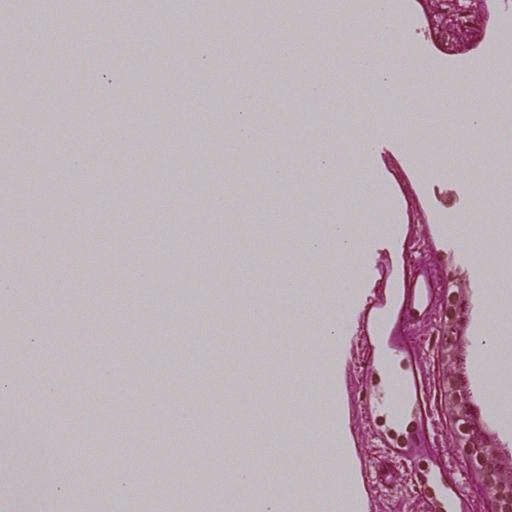

In [15]:
#check image
unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = unnormalized_image.cpu().numpy()
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [16]:
train_dataset = TrainDataSet(new_df_train,config,transforms=train_transforms,label=True)
val_dataset = TrainDataSet(new_df_train,config,transforms=val_transforms,label=True)
train_dataloader = DataLoader(train_dataset,batch_size=model_config.batch_size, num_workers = 0, pin_memory=True,shuffle=False,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=model_config.batch_size * 2, num_workers = 0, pin_memory=True,shuffle=False,collate_fn=collate_fn)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
original_images (512, 512, 3)
original_segmentation_maps (512, 512)


In [17]:
# class TrainDataSet_Test(Dataset):
#     # initialize df, label, imagepath and transforms
#     def __init__(self, imagepaths, maskpaths, transforms=None, label=True):
#         self.label = label
#         self.imagepaths = imagepaths
#         self.maskpaths = maskpaths
#         self.transforms = transforms
#
#     # define length, which is simply length of all imagepaths
#     def __len__(self):
#         return 1
#
#     # define main function to read image and label, apply transform function and return the transformed images.
#     def __getitem__(self, idx):
#         image_path = self.imagepaths
#         # print(image_path)
#         image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
#         original_image = np.array(image)
#         if self.label:
#             mask_path = self.maskpaths
#             # print(mask_path)
#             mask = cv2.imread(mask_path, 0)
#             original_segmentation_map = np.array(mask)
#         if self.transforms is not None:  #albumentations vs torchvision difference:
#             # # torchvision (randstain):
#             # image = self.transforms(image)
#             # #apply horizontal and vertical flips to image and mask
#             # if np.random.rand() < 0.5:
#             #     image = np.flipud(image)  #vertical
#             #     mask = np.flipud(mask)
#             # if np.random.rand() < 0.5:
#             #     image = np.fliplr(image)  #horizontal
#             #     mask = np.fliplr(mask)
#             # # Convert image and mask to tensors
#             # image = np.ascontiguousarray(image)
#             # image = np.transpose(image, (2, 0, 1))
#             # mask = np.ascontiguousarray(mask)
#             # image = torch.from_numpy(image.copy())  #.float()
#             # mask = torch.from_numpy(mask.copy()).unsqueeze(0)  #.to(torch.uint8)
#             #albumentation (no randstain):
#             transformed = self.transforms(image=original_image,mask=original_segmentation_map)
#             image = transformed['image']
#             segmentation_map = transformed['mask']
#             print(np.unique(segmentation_map,return_counts=True))
#             # mask = mask.unsqueeze(0)
#             # inputs = self.processor.encode_inputs(pixel_values_list=[image],segmentation_maps=[mask],return_tensors='pt')
#             # image = torch.float 32, mask = torch.uint8
#         # if self.transforms is None: # only for torchvision (randstain), for validation if no val_transforms
#         #     image = np.transpose(image, (2, 0, 1))
#         #     image = torch.from_numpy(image)
#         #     mask = torch.from_numpy(mask).unsqueeze(0)
#         return image, segmentation_map, original_image, original_segmentation_map  # return tensors of image arrays, image should be 3x 512 x 512, mask 1 x 512 x 512 (need dummy dimension to match dimension)

In [18]:
# train_dataset1 = TrainDataSet_Test(r"\\fatherserverdw\Kevin\hubmap\train_overlap\images\214866956ea3_top_right.tif",r"\\fatherserverdw\Kevin\hubmap\train_overlap\masks\blood_vessel\214866956ea3_top_right.tif"
# ,transforms=train_transforms,label=True)
# train_dataloader1 = DataLoader(train_dataset1,batch_size=model_config.batch_size, num_workers = 0, pin_memory=True,shuffle=False,collate_fn=collate_fn)
# batch1 = next(iter(train_dataloader1))
# for k,v in batch1.items():
#   if isinstance(v, torch.Tensor):
#     print(k,v.shape)
#   else:
#     print(k,v[0].shape)

In [15]:
from transformers import Mask2FormerForUniversalSegmentation
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)
model = model.to(model_config.device)

In [16]:
model

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value

In [19]:
# model = HubmapModel(config).to(model_config.device)
# model = Mask2FormerForUniversalSegmentation(config)
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)
model = model.to(model_config.device)
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay=model_config.weight_decay)  # default learning rate
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config.T_max,
                                               eta_min=model_config.eta_min)

train_dataset = TrainDataSet(new_df_train,config,transforms=train_transforms,label=True)
val_dataset = TrainDataSet(new_df_train,config,transforms=val_transforms,label=True)
train_dataloader = DataLoader(train_dataset,batch_size=model_config.batch_size, num_workers = 0, pin_memory=True,shuffle=False,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=model_config.batch_size * 2, num_workers = 0, pin_memory=True,shuffle=False,collate_fn=collate_fn)
print("Training for Fold {}".format(model_config.current_fold))
model, history = run_training(model, optimizer, scheduler,train_dataloader = train_dataloader, val_dataloader= val_dataloader,
                              device=model_config.device,
                              num_epochs=model_config.epochs)
pkl_save_path = os.path.join(model_config.model_save_directory, 'history.pickle')
#save history:
with open(pkl_save_path, 'wb') as file:
    pickle.dump(history, file)


Training for Fold 0
Current Epoch 1 / Total Epoch 2
Epoch 1/2

Train:   0%|          | 0/1369 [00:00<?, ?it/s]

Train:   0%|          | 0/1369 [00:00<?, ?it/s]


Validation:   0%|          | 0/685 [00:00<?, ?it/s]

TypeError: Mask2FormerImageProcessor.post_process_semantic_segmentation() missing 1 required positional argument: 'self'

In [ ]:
import os
import tifffile

def find_files_with_only_zeros(root_dir):
    zero_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".tif"):
                file_path = os.path.join(root, file)
                try:
                    # Read the binary mask file
                    binary_mask = tifffile.imread(file_path)
                    # Check if the binary mask contains only 0
                    if binary_mask.max() == 0:
                        zero_files.append(file)
                except Exception as e:
                    print(f"Error processing file '{file_path}': {e}")
    return zero_files

# Replace 'your_directory_path' with the path to the directory containing the .tif folders
directory_path = "your_directory_path"
zero_files_list = find_files_with_only_zeros(directory_path)

print("Files with only 0 pixel values:")
print(zero_files_list)
find_files_with_only_zeros(r"\\fatherserverdw\Kevin\hubmap\train_overlap\masks\blood_vessel")


In [ ]:
# ['458a92eda7b4_bot_right.tif',
#  '214866956ea3_top_right.tif',
#  '4c1361e4c2d8_bot_left.tif',
#  '578c8b32057e_top_left.tif',
#  'cbc4758c8c53_bot_right.tif',
#  '936f9bfb3966_top_right.tif',
#  'e5ac1caaadd8_bot_left.tif',
#  '27ac6c438f3b_top_left.tif',
#  '97f404585e68_bot_right.tif',
#  'aef16812206a_top_right.tif',
#  '8cb7d2ef7d2c_bot_left.tif',
#  '7aeb05949f93_top_left.tif',
#  '7aeb05949f93_bot_right.tif',
#  '76a3142ef6ee_top_right.tif',
#  '3fc432760114_bot_left.tif',
#  'cfcbc3b1aa48_top_left.tif',
#  '2b1cf5bbc9ea_bot_right.tif',
#  '9d3653466f61_top_right.tif',
#  '5e8476b465f9_bot_left.tif',
#  'e8758c97b189_top_left.tif',
#  '89184912fef8_bot_right.tif',
#  '4dae128831ab_top_right.tif',
#  'dcd2a14a9980_bot_left.tif',
#  '93c7422d2878_top_left.tif',
#  '3dee55fb6fcc_bot_right.tif',
#  '22db9740ba20_top_right.tif',
#  '590f64bf82a6_bot_left.tif',
#  'b3ee5e7bcf74_top_left.tif']

In [7]:
import pandas as pd
def remove_rows_by_names_from_excel(excel_file_path, names_to_remove):
    try:
        # Read the Excel file into a DataFrame
        df = pd.read_excel(excel_file_path)

        # Remove rows that contain any of the names from the list
        df = df[~df['id'].str.contains('|'.join(names_to_remove))]

        # Save the updated DataFrame back to the Excel file
        df.to_excel(excel_file_path, index=False)
        print("Rows with specified names have been removed successfully.")
    except Exception as e:
        print(f"Error occurred while processing the Excel file: {e}")

In [8]:
# Replace 'your_excel_file_path' with the path to your Excel file
excel_file_path = r"\\fatherserverdw\Kevin\hubmap\unet++_v2\val_fold0.xlsx"
names_list = ['458a92eda7b4_bot_right.tif',
 '214866956ea3_top_right.tif',
 '4c1361e4c2d8_bot_left.tif',
 '578c8b32057e_top_left.tif',
 'cbc4758c8c53_bot_right.tif',
 '936f9bfb3966_top_right.tif',
 'e5ac1caaadd8_bot_left.tif',
 '27ac6c438f3b_top_left.tif',
 '97f404585e68_bot_right.tif',
 'aef16812206a_top_right.tif',
 '8cb7d2ef7d2c_bot_left.tif',
 '7aeb05949f93_top_left.tif',
 '7aeb05949f93_bot_right.tif',
 '76a3142ef6ee_top_right.tif',
 '3fc432760114_bot_left.tif',
 'cfcbc3b1aa48_top_left.tif',
 '2b1cf5bbc9ea_bot_right.tif',
 '9d3653466f61_top_right.tif',
 '5e8476b465f9_bot_left.tif',
 'e8758c97b189_top_left.tif',
 '89184912fef8_bot_right.tif',
 '4dae128831ab_top_right.tif',
 'dcd2a14a9980_bot_left.tif',
 '93c7422d2878_top_left.tif',
 '3dee55fb6fcc_bot_right.tif',
 '22db9740ba20_top_right.tif',
 '590f64bf82a6_bot_left.tif',
 'b3ee5e7bcf74_top_left.tif'] # Replace this list with the one returned by the previous function


In [9]:
remove_rows_by_names_from_excel(excel_file_path, names_list)


Rows with specified names have been removed successfully.
